In [19]:
import torch
from torchvision import transforms, datasets
import torch.utils.data as data
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")

    # Losowość jest bardzo ważnym elementem trenowania sieci neuronowych (o czym się wkrótce przekonamy).Eksperymentując, chcielibyśmy jednak żeby przy każdym uruchomieniu programu, wynik był taki sam. Tylko w takim przypadku jesteśmy w stanie coś wnioskować. Do zapewnienia możliwości reprodukcji wyników na GPU za pomocą pytorcha służa poniższe komendy:

    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

else:
    device = torch.device("cpu")

print(device.type)

cuda


In [21]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

In [24]:
train_data = datasets.MNIST("data/", train=True, transform=transform, download=True)
test_data = datasets.MNIST("data/", train=False, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [66]:
train_data_loader = data.DataLoader(train_data, batch_size=512, shuffle=True, num_workers=10, pin_memory=True)
test_data_loader = data.DataLoader(test_data, batch_size=512, shuffle=True, num_workers=10, pin_memory=True)

In [117]:
len(train_data)

60000

In [31]:
image = next(iter(train_data))[0]

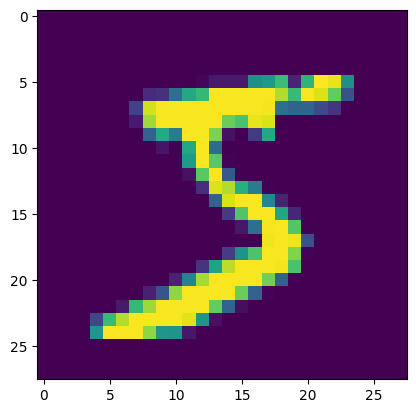

In [34]:
plt.imshow(image.view(28, 28))

In [39]:
flatten = nn.Flatten(start_dim=0, end_dim=2)
image_flat = flatten(image)
image_flat.shape

torch.Size([784])

# Model

In [60]:
class MnistClassifier(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.input_flat = nn.Flatten()
        self.input = nn.Linear(num_inputs, 512)
        self.hidden1 = nn.Linear(512, 128)
        self.output = nn.Linear(128, num_outputs)
        self.act_fn = nn.LeakyReLU()

    def forward(self, x):
        x = self.input_flat(x)
        x = self.input(x)
        x = self.act_fn(x)
        x = self.hidden1(x)
        x = self.act_fn(x)
        x = self.output(x)
        return x


In [71]:
model = MnistClassifier(28*28, 10)
model.to(device)

MnistClassifier(
  (input_flat): Flatten(start_dim=1, end_dim=-1)
  (input): Linear(in_features=784, out_features=512, bias=True)
  (hidden1): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (act_fn): LeakyReLU(negative_slope=0.01)
)

In [72]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_module = nn.CrossEntropyLoss()

In [73]:
device

device(type='cuda')

In [74]:
# Training loop
EPOCHS = 10
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    correct = 0
    total = 0
    for data_inputs, data_labels in train_data_loader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)


        logits = model(data_inputs)
        loss = loss_module(logits, data_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy calculation
        preds = logits.argmax(1)
        correct += (preds == data_labels).sum().item()
        total += data_labels.size(0)

    avg_loss = total_loss / len(train_data_loader)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

Epoch 1: Loss = 0.3866, Accuracy = 89.23%
Epoch 2: Loss = 0.1323, Accuracy = 96.01%
Epoch 3: Loss = 0.0832, Accuracy = 97.50%
Epoch 4: Loss = 0.0607, Accuracy = 98.12%
Epoch 5: Loss = 0.0456, Accuracy = 98.59%
Epoch 6: Loss = 0.0345, Accuracy = 98.97%
Epoch 7: Loss = 0.0271, Accuracy = 99.16%
Epoch 8: Loss = 0.0214, Accuracy = 99.33%
Epoch 9: Loss = 0.0151, Accuracy = 99.59%
Epoch 10: Loss = 0.0141, Accuracy = 99.59%


# Evaluation

In [95]:
model.eval() # Set model to eval mode
true_preds, num_preds = 0., 0.

test_y_hat = []
test_y = []
with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in test_data_loader:

        # Determine prediction of model on dev set
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        logits = model(data_inputs)
        pred_probabilites = nn.Softmax(dim=1)(logits)
        pred_labels = pred_probabilites.argmax(1)
        test_y_hat.append(pred_labels.to("cpu").numpy())
        test_y.append(data_labels.to("cpu").numpy())

        true_preds += (pred_labels == data_labels).sum()
        num_preds += data_labels.shape[0]

acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 98.12%


In [100]:
test_y = np.concatenate(test_y)

In [101]:
test_y_hat = np.concatenate(test_y_hat)

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [103]:
cm = confusion_matrix(test_y, test_y_hat)

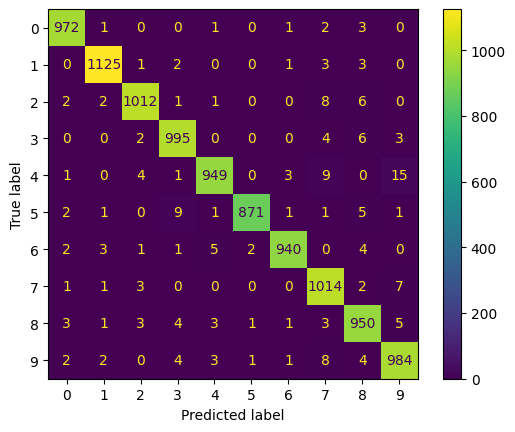

In [106]:
disp = ConfusionMatrixDisplay(cm, display_labels=[str(x) for x in range(10)])
disp.plot()
plt.show()



In [116]:
from torchviz import make_dot
from torchview import draw_graph


model_graph = draw_graph(MnistClassifier(28*28, 10), input_size=(1, 28, 28))
model_graph.visual_graph.render(format="png")

'model.gv.png'